# 1. Preliminaries

In [2]:
##!pip3 install qutip
import qutip as qp
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
import pandas as pd
from random import random, choice, randint
##from multiprocessing import Pool
##from concurrent.futures import ThreadPoolExecutor

# 2. Gell_Mann matrix generator function

this function will generate the gellmann matrix of dimension d.

the function "gellmann(j,k,d)" will generate the jth_kth gellmann matrix of dimension d. so for every d dimension we have d^2 gellmann matrix. one of them is I, so the number of gellmann matrix that is not trivial is (d^2 - 1).

In [3]:
"""Generate generalized Gell-Mann matrices.
  .. module:: gellmann.py
     :synopsis: Generate generalized Gell-Mann matrices
  .. moduleauthor:: Jonathan Gross <jarthurgross@gmail.com>
"""
from itertools import product

def gellmann(j, k, d):
    r"""Returns a generalized Gell-Mann matrix of dimension d.
    
    According to the convention in *Bloch Vectors for Qubits* by Bertlmann and
    Krammer (2008), returns :math:`\Lambda^j` for :math:`1\leq j=k\leq d-1`,
    :math:`\Lambda^{kj}_s` for :math:`1\leq k<j\leq d`, :math:`\Lambda^{jk}_a`
    for :math:`1\leq j<k\leq d`, and :math:`I` for :math:`j=k=d`.
    Parameters
    ----------
    j : positive integer
        Index for generalized Gell-Mann matrix
    k : positive integer
        Index for generalized Gell-Mann matrix
    d : positive integer
        Dimension of the generalized Gell-Mann matrix
    Returns
    -------
    numpy.array
        A genereralized Gell-Mann matrix.
    """

    if j > k:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = 1
        gjkd[k - 1][j - 1] = 1
    elif k > j:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = -1.j
        gjkd[k - 1][j - 1] = 1.j
    elif j == k and j < d:
        gjkd = np.sqrt(2/(j*(j + 1)))*np.diag([1 + 0.j if n <= j
                                               else (-j + 0.j if n == (j + 1)
                                                     else 0 + 0.j)
                                               for n in range(1, d + 1)])
    else:
        gjkd = np.diag([1 + 0.j for n in range(1, d + 1)])

    return gjkd

def get_basis(d):
    r"""Return a basis of operators.
    
    The basis is made up of orthogonal Hermitian operators on a Hilbert space
    of dimension d, with the identity element in the last place.
    Parameters
    ----------
    d : int
        The dimension of the Hilbert space.
    Returns
    -------
    list of numpy.array
        The basis of operators.
    """
    return [gellmann(j, k, d) for j, k in product(range(1, d + 1), repeat=2)]

in this cell the gellmann matrix of 3 dimension will generate and they will save in a dictionary and labeled them by numbers 0,1,...,8 .

In [4]:
def gellmann_basis(d):
    """ generalization gellmann matrice  
    input : dimesion of system
    output: dictionary of gellmann matrices of dimension 'd'
    """
    
    gellmann_basis = {}  ## a dictionary that saved the gellmann matrices

    k=0
    for i in range(1,d+1):
        for j in range(1,d+1):
            gellmann_basis.update({"G{}".format(k):gellmann(i,j,d)})
            k+=1
        
    return gellmann_basis

#gellmann_basis(3)

# 3. Coefficients of gellmann's expansion

at this cell a random density matrix will generate by qutip library.

for calculating the coefficients of gellmann expansion we do this iteration:
1. calculate the tensor product of gellmann matrices for every coefficient
2. calculate the dot product of "ro" and the "gellmann's tensor product"
3. calculate the trace of this matrix and divide it into 4
4. append it to our index list

In [5]:
def coef_of_gellmann(ro, d_sub1, d_sub2):
    """ coefficient of gellmann expansion 
    input : density matrix and dimensions of two subsystem
    output: dictionary of coefficient
    """
    
    coef = {}  ## the coefficient's dictionary (suitable format for saving as a data)
    gellmann_basis_d_sub1 = gellmann_basis(d_sub1) ## the gellmann matrix for a d_sub1 dimension system
    gellmann_basis_d_sub2 = gellmann_basis(d_sub2) ## the gellmann matrix for a d_sub2 dimension system
    
    n1 = d_sub1**2
    n2 = d_sub2**2
    for i in range(n1):
        for j in range(n2):
            tensorP = np.kron(gellmann_basis_d_sub1["G{}".format(i)],gellmann_basis_d_sub2["G{}".format(j)]) ## Tensor product of gelllmann matrices
            c = np.trace(np.dot(ro,tensorP))/4   ## dot product and trace
            c = c.real       ## all of gellmann coefs is a real
            c = round(c,8)  
            coef.update({"a{}{}".format(i,j):c})  ## update the coef dict by a[i][j] and its gellmann coef for g[i][j]

    index = np.array(coef)  ## change list to np.array() object
    return coef

this cell is just a test of this algotithm in 3 dimension bipatite systems.

In [6]:
N = 3

ro = qp.rand_dm(N*N,0.5,dims=[[N,N], [N,N]])
#print(coef_of_gellmann(ro))

# 4. Generate entangled states (PPT)

In this cell we define a PPT funcion that check positive partial transpose.

In [7]:
def PPT(ro, d_sub1, d_sub2):
    """ positive partial transpose 
    input : density matrix and the dimension of subsystem 1 and subsystem 2
    output: dictionary of  coefficient of gellmann matrices and label 1 or 2 for entangeled states and unknown respectivly
    """
    
    ro_pt = qp.partial_transpose(ro,[0,1])  ## partial transpose in subsystem 2
    eig = ro_pt.eigenstates()   ## calculate the eigenvalues and eigenstates
    eigv = [round(i,8) for i in eig[0]] 
    
    result = coef_of_gellmann(ro, d_sub1, d_sub2)
    
    if (eigv[0]<0 ):
            result.update({"label":1})  ## the entangled states that labeled by 1
            return result
    else :
            result.update({"label":2})  ## the unknown states that labeled by 2
            return result


# 5. Generate separable states (Convex combination)

in this cell we define two function that:
1. Convex_Combination: this function is give a matrix list and return a convex combination of this matrices
2. generate_ran_den_list: this function is generate a list of random density matrices

In [8]:
def Convex_Combination(matrix_list1, matrix_list2, index=10):
    """ Convex Combination 
    input : two list of matrices that you want to build a convex combination of them. index is the number of iteration
    output: a state that is a convex combination of input
    """
    
    coef = np.random.dirichlet(np.ones(index), size=1)   ## generating list of numbers that is positive and its sum is 1 with length equal to 'index'
    
    seprable_state = qp.Qobj()    ## build an empty Qobj for cycle
    for i in range(index):
        a = choice(matrix_list1)   ## choice a density matrix randomly
        b = choice(matrix_list2)   ## choice a density matrix randomly
        
        tensorP = np.kron(a,b) ## Tensor product of density matrices
        tensorP *= round(coef[0][i],8)  ## product of tensorP and a coef that come from the coef list
        
        seprable_state += tensorP  ## at the last its a convex combination of tensor product of density matrices
    
    return seprable_state


def generate_ran_den_list(d, length= 100):
    """ generate random density matrix list 
    input : dimension of system and the lenght of list
    output: list of random density matrix with dimension 'd'
    """
    
    result = []
    for i in range(length):
        density = round(random(),4)     ## for build a random number between 0 and 1

        rand = qp.rand_dm(d, density)   ## generate a random density matrix with dimension N
        result.append(rand)        ## appending this random density matrix to ran_den_mat list    
    
    return result

# 6. Convex hull approximation method

Making a Convex Hull for a 2_qutrit system and checking for new points in the convex Hull

In [20]:
d_sub1 = 3
d_sub2 = 3
num_extreme_points = 83
index = np.zeros((1,81))

for i in range(num_extreme_points):
    ro = qp.rand_dm(d_sub1 * d_sub2, pure=True)

    coef = list(coef_of_gellmann(ro, d_sub1, d_sub2).values())
    coef = np.reshape(np.array(coef),(1,81))
    index = np.vstack((index,coef))
#print(np.shape(index[1:,]))

Using different functions to build convex hull

In [7]:
#generating convex hull from extreme points(Pure separable states)
hull = Delaunay(index)
#hull = ConvexHull(index)
#print(index)

The function that checks if a point is in a convex hull

In [8]:
#This function checks if a point is in the convex hull or not
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

Test

In [26]:
ro = qp.rand_dm(9) ## generate the random density matrix

coef = list(coef_of_gellmann(ro,3,3).values())
coef = np.reshape(np.array(coef),(1,81)) 

#print(coef)
print(in_hull(index[20:,],index))

Making a Convex Hull for a 2_qubit system and checking for new points in the convex Hull.

In [23]:
d_sub1 = 2
d_sub2 = 2
num_extreme_points = 20
index = np.zeros((1,16))

for i in range(num_extreme_points):
    ro = qp.rand_dm(d_sub1 * d_sub2, pure=True)
    
    coef = list(coef_of_gellmann(ro, d_sub1, d_sub2).values())
    coef = np.reshape(np.array(coef),(1,16))
    index = np.vstack((index,coef))
#print(np.real(index[1:,]))

In [25]:
hull = ConvexHull(index[:,])
in_hull(index[2,],index)

True

# 7. Generate data

in this cell we build 100 000 random states and labeled that. after that we build a data frame for saving and using in future.

In [11]:
%%time

states={} #states
d_sub1 = 3 #dimension of subsystem 1
d_sub2 = 3 #dimension of subsystem 2
R1 = 50000   # the number of entangled states

##generate the entangled states
for i in range (1, R1+1):
    density = round(random(),4)     ## for build a random number between 0 and 1
    
    ro = qp.rand_dm(d_sub1*d_sub2, density, dims=[[d_sub1,d_sub2], [d_sub1,d_sub2]])     #generating random density matrix with a random density
    states.update({"{}".format(i):PPT(ro, d_sub1, d_sub2)})     # update the states by its number and label and gellmann coefs


##generate the separable states
R2 = 50000  # the number of seperable states
ran_den_mat1 = generate_ran_den_list(d_sub1, 100) ## a list of random density matrix for a system
ran_den_mat2 = generate_ran_den_list(d_sub2, 100) ## a list of random density matrix for a system

for i in range(R1+1, R1+R2+1):
    index = randint(10,100)   ## build a integer number between 10 and 100 for using in function
    sep = Convex_Combination(ran_den_mat1, ran_den_mat2, index)  ## generate a random seprable density matrix
    
    sep_coef = coef_of_gellmann(sep, d_sub1, d_sub2)   ## calculate the gellmann coefs
    sep_coef.update({"label":0})   ## labeled seprable states by 0
    
    states.update({"{}".format(i):sep_coef})  ## update states
    
    
df = pd.DataFrame(data=states).T  # build a data frame by pandas

df.to_csv('data_of_states.csv.zip')  #for saving the data in zip format
#df.to_excel('data_of_states.xlsx')  #for saving tha data in an excel file

in this cell we save our data frame as a zip file

In [19]:
df.to_csv('data_of_states.csv.zip')
##df.to_csv('data_of_states.csv')

in the blow cell we define a function that merge all of our data to a one data.

In [2]:
def merge(list_data):
    N = len(list_data)  #the number of datas
    n = [len(i.index) for i in list_data]  # length of index of every data
    
    new_datas = [list_data[0]]
    index = {}
    k = n[0]
    for i in range(1,N):
        last_index, new_index = [i for i in range(1,n[i]+1)], []
        for j in range(1+k, n[i]+1+k):
            new_index.append(j)
            
        index = {last_index[p]:new_index[p] for p in range(n[i])}
        df = list_data[i]
        df = df.rename(index = index)
        new_datas.append(df)
        k += n[i]
    
    result_data = pd.concat(new_datas)
    return result_data

this function dont true work because of 'memory error'.

so we dont merge datas and just fix their index for future.

at this cell we read the unfixed datas. after that we drop the 'a88' column, because it's same for all.

In [2]:
#df1 = pd.read_csv('data/data_of_states1.csv.zip', index_col=0, compression = 'zip')
#df2 = pd.read_csv('data/data_of_states2.csv.zip', index_col=0, compression = 'zip')
#df3 = pd.read_csv('data/data_of_states3.csv.zip', index_col=0, compression = 'zip')
#df4 = pd.read_csv('data/data_of_states4.csv.zip', index_col=0, compression = 'zip')
#df5 = pd.read_csv('data/data_of_states5.csv.zip', index_col=0, compression = 'zip')
#df6 = pd.read_csv('data/data_of_states6.csv.zip', index_col=0, compression = 'zip')
#df7 = pd.read_csv('data/data_of_states7.csv.zip', index_col=0, compression = 'zip')
#df8 = pd.read_csv('data/data_of_states8.csv.zip', index_col=0, compression = 'zip')
#df9 = pd.read_csv('data/data_of_states_100.csv.zip', index_col=0, compression = 'zip')
#df10 = pd.read_csv('data/data_of_states_200.csv.zip', index_col=0, compression = 'zip')

df = df.drop(columns=['a88'])

in this cell we fixed (rename) the index.

In [4]:
k = 1000000

a = [i for i in range(1,100000+1)]
b = [i for i in range(k+1,k+100000+1)]
c = {a[i]:b[i] for i in range(len(a))}

df = df.rename(index = c)

In [6]:
#df10.to_csv('fixed_data/data_of_states_10(100 k).csv.zip')
#df1.to_csv('fixed_data/data_of_states_2(100 k).csv.zip')
#df2.to_csv('fixed_data/data_of_states_3(100 k).csv.zip')
#df3.to_csv('fixed_data/data_of_states_4(100 k).csv.zip')
#df4.to_csv('fixed_data/data_of_states_5(100 k).csv.zip')
#df5.to_csv('fixed_data/data_of_states_6(100 k).csv.zip')
#df6.to_csv('fixed_data/data_of_states_7(100 k).csv.zip')
#df7.to_csv('fixed_data/data_of_states_8(100 k).csv.zip')
#df8.to_csv('fixed_data/data_of_states_9(100 k).csv.zip')
#df9.to_csv('fixed_data/data_of_states_10(100 k).csv.zip')

# 8. Correlation of data

the plot shows the correlation of 100000 random states

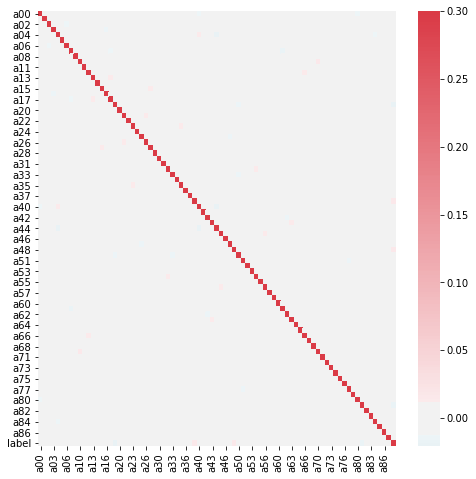

In [4]:
import matplotlib.pyplot as plt
import seaborn

#import the data
df = pd.read_csv('fixed_data/data_of_states_4(100 k).csv.zip', index_col=0, compression = 'zip')

# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#data_mini = d.sample(10000)
seaborn.heatmap(corr, cmap=cmap, vmax=.3, center=0)
plt.show()